# **Importing necessary libraires**

In [33]:
import sys
import gc
import optuna

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from tokenizers import (decoders,models,normalizers,pre_tokenizers,processors,trainers,Tokenizer,)
from datasets import Dataset
from tqdm.auto import tqdm
from transformers import PreTrainedTokenizerFast

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,VotingClassifier

# **Using pandas to read the dataset**

In [34]:
test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')

sub = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')

org_train = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')

train = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv", sep=',')

# **Exploring the original train dataset**

In [35]:
org_train.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


# **Understanding the skewness of the dataset**

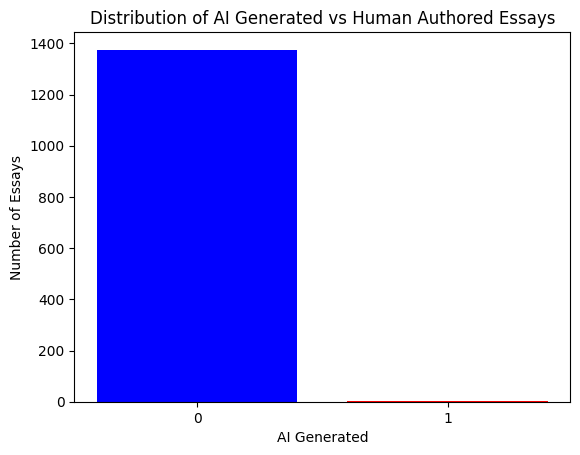

In [36]:
counts = org_train['generated'].value_counts()
plt.bar(counts.index, counts.values, color=['blue', 'red'])
custom_ticks = [0, 1]
plt.xticks(custom_ticks)
plt.xlabel('AI Generated')
plt.ylabel('Number of Essays')
plt.title('Distribution of AI Generated vs Human Authored Essays')
plt.show()

# **Exploring the external train dataset**

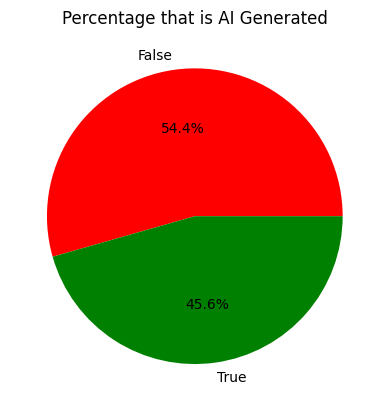

In [37]:
counts = train['RDizzl3_seven'].value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=['red', 'green'])
plt.title('Percentage that is AI Generated')
plt.show()

# **Removing duplicate rows and resetting the index of the dataframe**

In [38]:
train = train.drop_duplicates(subset=['text'])

train.reset_index(drop=True, inplace=True)

# **Using BERT base model vocabulary size**

In [39]:
LOWERCASE = False
VOCAB_SIZE = 30522 

# **Setting up and training Byte Pair Encoding tokenizer**

In [40]:
raw = Tokenizer(models.BPE(unk_token="[UNK]"))

raw.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw.pre_tokenizer = pre_tokenizers.ByteLevel()

special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)

ok = Dataset.from_pandas(test[['text']])

def train_corp_iter(): 
    for i in range(0, len(ok), 1000):
        yield ok[i : i + 1000]["text"]

raw.train_from_iterator(train_corp_iter(), trainer=trainer)

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

tt_test = []
for text in tqdm(test['text'].tolist()):
    tt_test.append(tokenizer.tokenize(text))
    
tt_train = []
for text in tqdm(train['text'].tolist()):
    tt_train.append(tokenizer.tokenize(text))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/44868 [00:00<?, ?it/s]

# **Customizing TF-IDF Vectorizer with Dummy Function and Vocabulary Restriction for Text Transformation**

In [41]:
def myfunction(text):
    return text

hello = TfidfVectorizer(
    ngram_range=(3, 5),
    lowercase=False,
    sublinear_tf=True,
    analyzer='word',
    tokenizer=myfunction,
    preprocessor=myfunction,
    token_pattern=None,
    strip_accents='unicode'
)

hello.fit(tt_test)

vocab = hello.vocabulary_
print(vocab)

hello = TfidfVectorizer(
    ngram_range=(3, 5),
    lowercase=False,
    sublinear_tf=True,
    vocabulary=vocab,
    analyzer='word',
    tokenizer=myfunction,
    preprocessor=myfunction,
    token_pattern=None,
    strip_accents='unicode'
)
tf_train = hello.fit_transform(tt_train)
tf_test = hello.transform(tt_test)

del hello
gc.collect()

{'ĠAaa Ġbbb Ġccc': 0, 'Ġbbb Ġccc .': 6, 'ĠAaa Ġbbb Ġccc .': 1, 'ĠBbb Ġccc Ġddd': 2, 'Ġccc Ġddd .': 7, 'ĠBbb Ġccc Ġddd .': 3, 'ĠCCC Ġddd Ġeee': 4, 'Ġddd Ġeee .': 8, 'ĠCCC Ġddd Ġeee .': 5}


46252

# **Extracting the labels (target variable) from the train DataFrame and storing them in the variable y_train.**

In [42]:
y_train = train['label'].values

# **Ensemble Model with Logistic Regression and SGD Classifier**

In [43]:
# Conditional Check for Test Data Size
if len(test.text.values) <= 5:
    sub.to_csv('submission.csv', index=False)
else:
    from sklearn.linear_model import LogisticRegression

    # Initialize Logistic Regression Model
    logreg_model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
    sgd_model = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber") 

    # Ensemble Model (Voting Classifier)
    weights = [0.6, 0.4]
    ensemble = VotingClassifier(estimators=[('logreg', logreg_model),
                                            ('sgd', sgd_model),
                                           ],
                                weights=weights, voting='soft', n_jobs=-1)
    # Model Training
    ensemble.fit(tf_train, y_train)
    gc.collect()

    # Making Predictions
    prediction = ensemble.predict_proba(tf_test)[:, 1]

    # Updating Submission DataFrame
    sub['generated'] = prediction

    # Saving Submission to CSV
    sub.to_csv('submission.csv', index=False)

    # Displaying the Submission DataFrame
    sub